In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [ ]:
! unzip /content/train_triplets.txt

unzip:  cannot find or open /content/train_triplets.txt, /content/train_triplets.txt.zip or /content/train_triplets.txt.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/train_triplets.txt', sep='\t', names=['user_id', 'song_id', 'listen_count'])

In [ ]:
# Limit the number of users and songs to make training faster
num_users = 10000
num_songs = 5000
data_df = data_df[data_df['user_id'].isin(data_df['user_id'].value_counts().index[:num_users])]
data_df = data_df[data_df['song_id'].isin(data_df['song_id'].value_counts().index[:num_songs])]

In [ ]:
# Label encode the user and song IDs
user_encoder = LabelEncoder()
user_encoder.fit(data_df['user_id'])
data_df['user_id'] = user_encoder.transform(data_df['user_id'])
song_encoder = LabelEncoder()
song_encoder.fit(data_df['song_id'])
data_df['song_id'] = song_encoder.transform(data_df['song_id'])

In [ ]:
# Split the data into training and test sets
train_df = data_df.sample(frac=0.8, random_state=42)
test_df = data_df.drop(train_df.index)

In [ ]:
# Define the embedding dimension
embedding_dim = 32

In [ ]:
# Define the user and song input layers
user_input = Input(shape=(1,))
song_input = Input(shape=(1,))

In [ ]:
# Define the user and song embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
user_embedding = Flatten()(user_embedding)
song_embedding = Embedding(input_dim=num_songs, output_dim=embedding_dim)(song_input)
song_embedding = Flatten()(song_embedding)

In [ ]:
# Concatenate the user and song embeddings
concatenated = Concatenate()([user_embedding, song_embedding])

In [ ]:
# Add dropout to prevent overfitting
concatenated = Dropout(0.5)(concatenated)

# Define the dense layers
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)

In [ ]:
# Define the output layer
output_layer = Dense(1)(dense3)

In [ ]:
# Define the model
model = Model(inputs=[user_input, song_input], outputs=output_layer)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [ ]:
# Train the model
model.fit([train_df['user_id'], train_df['song_id']], train_df['listen_count'], batch_size=128, epochs=10, verbose=1)

Epoch 1/10
9124/9124 [==============================] - 96s 10ms/step - loss: 17.5119
Epoch 2/10
9124/9124 [==============================] - 92s 10ms/step - loss: 17.1144
Epoch 3/10
9124/9124 [==============================] - 98s 11ms/step - loss: 16.9420
Epoch 4/10
9124/9124 [==============================] - 103s 11ms/step - loss: 16.8497
Epoch 5/10
9124/9124 [==============================] - 91s 10ms/step - loss: 16.7553
Epoch 6/10
9124/9124 [==============================] - 94s 10ms/step - loss: 16.6566
Epoch 7/10
9124/9124 [==============================] - 91s 10ms/step - loss: 16.6567
Epoch 8/10
9124/9124 [==============================] - 93s 10ms/step - loss: 16.5724
Epoch 9/10
9124/9124 [==============================] - 91s 10ms/step - loss: 16.5677
Epoch 10/10
9124/9124 [==============================] - 93s 10ms/step - loss: 16.5419


In [ ]:
# Save your model
import pickle
with open('ncf.pickle', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
with open('ncf.pickle', 'rb') as f:
  model = pickle.load(f)

In [ ]:
# Evaluate the model on the test set
score = model.evaluate([test_df['user_id'], test_df['song_id']], test_df['listen_count'], verbose=0)
print('Test loss:', score)

Test loss: 16.444597244262695


In [ ]:
# Make predictions on the test set
y_pred = model.predict([test_df['user_id'], test_df['song_id']])
y_true = test_df['listen_count'].values



9124/9124 [==============================] - 20s 2ms/step


In [ ]:
y_pred.flatten()

array([4.614843 , 2.7762396, 3.104034 , ..., 2.334949 , 2.635333 ,
       2.153445 ], dtype=float32)

In [ ]:
y_true

array([7, 3, 5, ..., 1, 1, 4])

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
rmse

4.055185053352839

In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming y_true and y_pred are the true and predicted values respectively
mae = mean_absolute_error(y_true, y_pred)

In [ ]:
mae

1.705204609504401

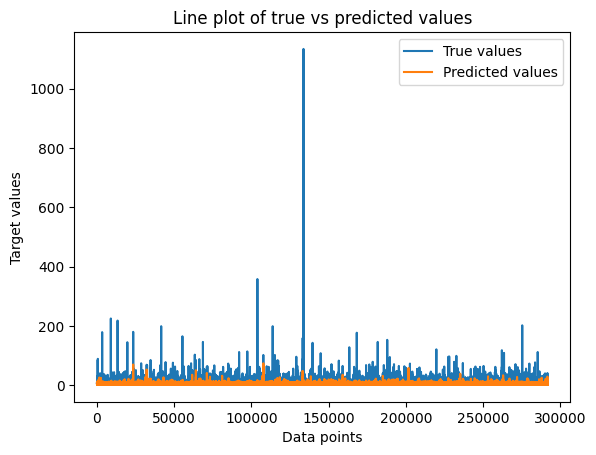

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true, label='True values')
plt.plot(y_pred, label='Predicted values')
plt.xlabel('Data points')
plt.ylabel('Target values')
plt.title('Line plot of true vs predicted values')
plt.legend()
plt.show()

In [ ]:
user = 3574
songs = test_df.loc[test_df['user_id'] == user]['song_id'].unique()
preference_scores = model.predict([np.full(len(songs), user), songs])
song_scores = list(zip(songs, preference_scores.flatten()))
sorted_song_scores = sorted(song_scores, key=lambda x: x[1], reverse=True)
top_songs = [song for song, score in sorted_song_scores[:10]]

print("Top 10 recommendations for user 3574:")
for i, song in enumerate(top_songs):
    print(f"{i+1}. {song}")

3/3 [==============================] - 0s 4ms/step
Top 10 recommendations for user 3574:
1. 1031
2. 3144
3. 2642
4. 3600
5. 4363
6. 745
7. 112
8. 963
9. 3220
10. 2580


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
# Load the train_triplets.txt file
df = pd.read_csv('/content/drive/MyDrive/train_triplets.txt', sep='\t', header=None, names=['user_id', 'song_id', 'listen_count'])


In [ ]:
print(df.head())

                                    user_id             song_id  listen_count
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995             1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9             1
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B             2
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22             1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494             1


In [ ]:
# Convert data types
df['user_id'] = df['user_id'].astype('category').cat.codes.values
df['song_id'] = df['song_id'].astype('category').cat.codes.values


In [ ]:
# Create train and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Define the number of users, songs, and embedding size
num_users = len(df.user_id.unique())
num_songs = len(df.song_id.unique())
embedding_size = 32

In [ ]:
# Define the MLP model
user_input = tf.keras.layers.Input(shape=(1,))
song_input = tf.keras.layers.Input(shape=(1,))

In [ ]:
# Concatenate the input embeddings
input_embeddings = tf.keras.layers.Concatenate()([user_input, song_input])

In [ ]:
# Add dense layers with dropout
dense1 = tf.keras.layers.Dense(units=64, activation='relu')(input_embeddings)
dropout1 = tf.keras.layers.Dropout(rate=0.2)(dense1)
dense2 = tf.keras.layers.Dense(units=32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(dense2)

In [ ]:
# Output layer with linear activation
output_layer = tf.keras.layers.Dense(units=1, activation='linear')(dropout2)

In [ ]:
# Create the model
model = tf.keras.models.Model(inputs=[user_input, song_input], outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

In [ ]:
# Train the model
model.fit([train_data['user_id'], train_data['song_id']], train_data['listen_count'], batch_size=128, epochs=10, verbose=1, validation_data=([val_data['user_id'], val_data['song_id']], val_data['listen_count']))

Epoch 1/10
302335/302335 [==============================] - 957s 3ms/step - loss: 775416.5000 - val_loss: 50.3196
Epoch 2/10
302335/302335 [==============================] - 945s 3ms/step - loss: 39.2793 - val_loss: 50.3196
Epoch 3/10
302335/302335 [==============================] - 924s 3ms/step - loss: 39.2998 - val_loss: 50.3197
Epoch 4/10
302335/302335 [==============================] - 900s 3ms/step - loss: 39.4061 - val_loss: 50.3202
Epoch 5/10
302335/302335 [==============================] - 899s 3ms/step - loss: 39.2266 - val_loss: 50.3199
Epoch 6/10
302335/302335 [==============================] - 858s 3ms/step - loss: 39.2948 - val_loss: 50.3196
Epoch 7/10
302335/302335 [==============================] - 895s 3ms/step - loss: 39.3009 - val_loss: 50.3197
Epoch 8/10
302335/302335 [==============================] - 860s 3ms/step - loss: 39.2292 - val_loss: 50.3198
Epoch 9/10
302335/302335 [==============================] - 922s 3ms/step - loss: 39.2263 - val_loss: 50.3197
Epoch 

In [ ]:
# Save your model
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
with open('model.pickle', 'rb') as f:
  model = pickle.load(f)


In [ ]:
# Evaluate the model on test data
test_data = pd.read_csv('/content/drive/MyDrive/train_triplets.txt', header=None, delimiter='\t')


In [ ]:
test_data = test_data.sample(n=10000, random_state=42,replace = True)
test_data.to_csv('train_triplets_small.txt', sep='\t', index=False, header=False)
test_data.columns = ['user_id', 'song_id', 'listen_count']
test_data['user_id'] = test_data['user_id'].astype('category').cat.codes.values
test_data['song_id'] = test_data['song_id'].astype('category').cat.codes.values
y_true = test_data['listen_count']
y_pred = model.predict([test_data['user_id'], test_data['song_id']])

313/313 [==============================] - 1s 1ms/step


In [ ]:
y_true

28474248    1
7904069     2
31087640    2
19108564    1
9472917     2
           ..
5301572     1
39858177    1
40381731    1
41096018    1
39648899    1
Name: listen_count, Length: 10000, dtype: int64

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)

print("MAE:", mae)

MAE: 2.358693572616577


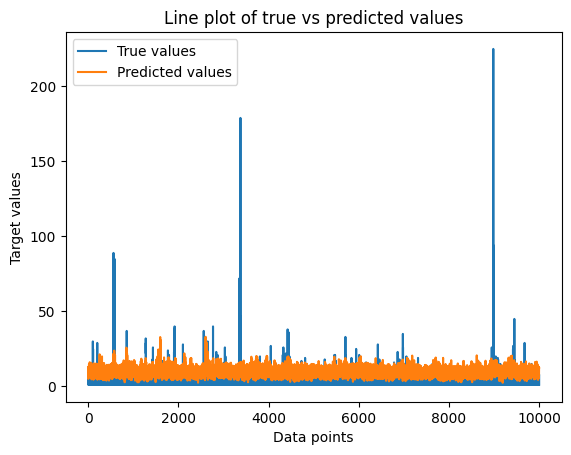

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true, label='True values')
plt.plot(y_pred, label='Predicted values')
plt.xlabel('Data points')
plt.ylabel('Target values')
plt.title('Line plot of true vs predicted values')
plt.legend()
plt.show()

In [ ]:
# Get all unique song IDs
all_song_ids = df.song_id.unique()

In [ ]:
# Select a sample user ID to generate recommendations for
sample_user_id = 3574
user_ids = np.array([sample_user_id] * len(all_song_ids))

In [ ]:
# Predict the listen count for all songs for the selected user
predicted_listen_count = model.predict([user_ids, all_song_ids])

12018/12018 [==============================] - 22s 2ms/step


In [ ]:
# Get the indices that would sort the predicted listen count in descending order
sorted_indices = np.argsort(predicted_listen_count, axis=0)[::-1]

In [ ]:
# Get the top N recommended songs
top_n = 10
print(all_song_ids)
recommended_songs = all_song_ids[sorted_indices[:top_n]]

[  6347   9365  16962 ... 312844 168490  34337]


In [ ]:
# Print the recommended songs
print(recommended_songs)

[[ 34337]
 [326273]
 [300462]
 [304640]
 [310966]
 [311612]
 [313774]
 [314016]
 [318762]
 [321540]]
